In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_absolute_error, mean_squared_error

#### Data Preparation and Exploration

In [3]:
data=pd.read_csv("exchange_rate.csv")
data.head()

,date,Ex_rate
0,01-01-1990 00:00,0.7855
1,02-01-1990 00:00,0.7818
2,03-01-1990 00:00,0.7867
3,04-01-1990 00:00,0.7860
4,05-01-1990 00:00,0.7849


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7588 entries, 0 to 7587
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   date     7588 non-null   object 
 1   Ex_rate  7588 non-null   float64
dtypes: float64(1), object(1)
memory usage: 118.7+ KB


In [5]:
data.isnull().sum()

date       0
Ex_rate    0
dtype: int64

In [6]:
data.describe()

,Ex_rate
count,7588.000000
mean,0.776974
std,0.136620
min,0.483297
25%,0.701422
50%,0.761377
75%,0.873477
max,1.102536


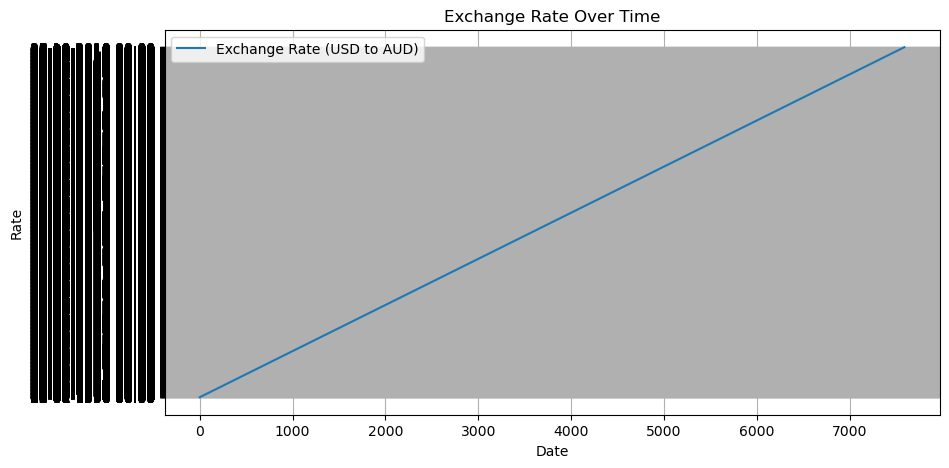

In [19]:
# Plot time series
plt.figure(figsize=(10, 5))
plt.plot(data.iloc[:,0], label='Exchange Rate (USD to AUD)')
plt.title("Exchange Rate Over Time")
plt.xlabel("Date")
plt.ylabel("Rate")
plt.legend()
plt.grid(True)
plt.show()

##### ARIMA Model Building

In [20]:
# Check stationarity with Augmented Dickey-Fuller test
result = adfuller(data['Ex_rate'])
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

ADF Statistic: -1.664994180738078
p-value: 0.44923273535982894


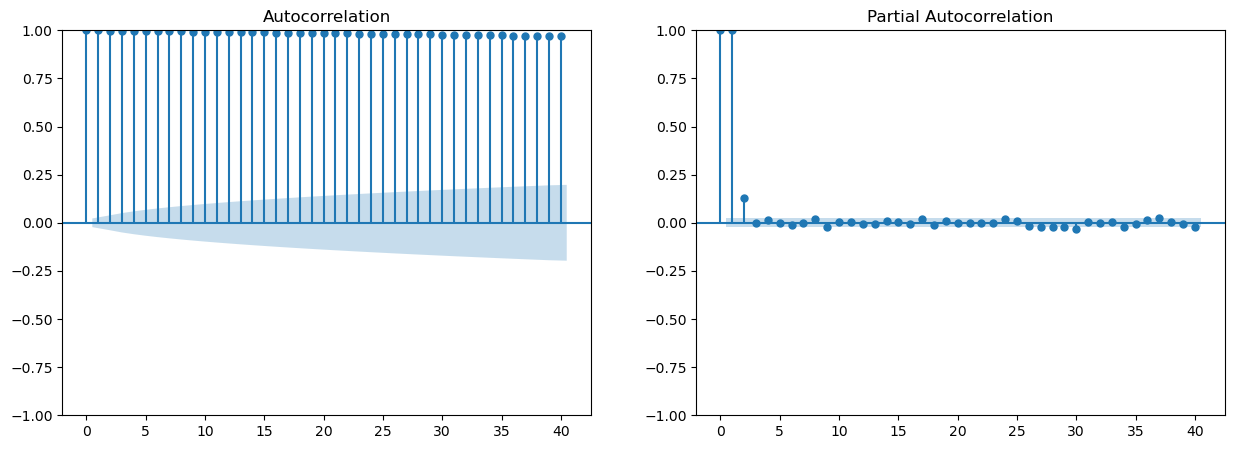

In [21]:
# Plot ACF and PACF for parameter estimation
fig, axes = plt.subplots(1,2, figsize=(15,5))
plot_acf(data['Ex_rate'], lags=40, ax=axes[0])
plot_pacf(data['Ex_rate'], lags=40, ax=axes[1])
plt.show()

In [22]:
# Determine order (p,d,q): For example, if non-stationary try d=1
p, d, q = 2, 1, 2  # Adjust after ACF/PACF inspection

# Splitting data into train/test
train = data.iloc[:-12]
test = data.iloc[-12:]

In [23]:
# Fit ARIMA model
model_arima = ARIMA(train['Ex_rate'], order=(p,d,q))
model_arima_fit = model_arima.fit()
print(model_arima_fit.summary())


                               SARIMAX Results                                
Dep. Variable:                Ex_rate   No. Observations:                 7576
Model:                 ARIMA(2, 1, 2)   Log Likelihood               28005.398
Date:                Mon, 27 Oct 2025   AIC                         -56000.796
Time:                        19:44:19   BIC                         -55966.133
Sample:                             0   HQIC                        -55988.899
                               - 7576                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1140      0.584     -0.195      0.845      -1.258       1.030
ar.L2          0.1136      0.088      1.298      0.194      -0.058       0.285
ma.L1         -0.0175      0.584     -0.030      0.9

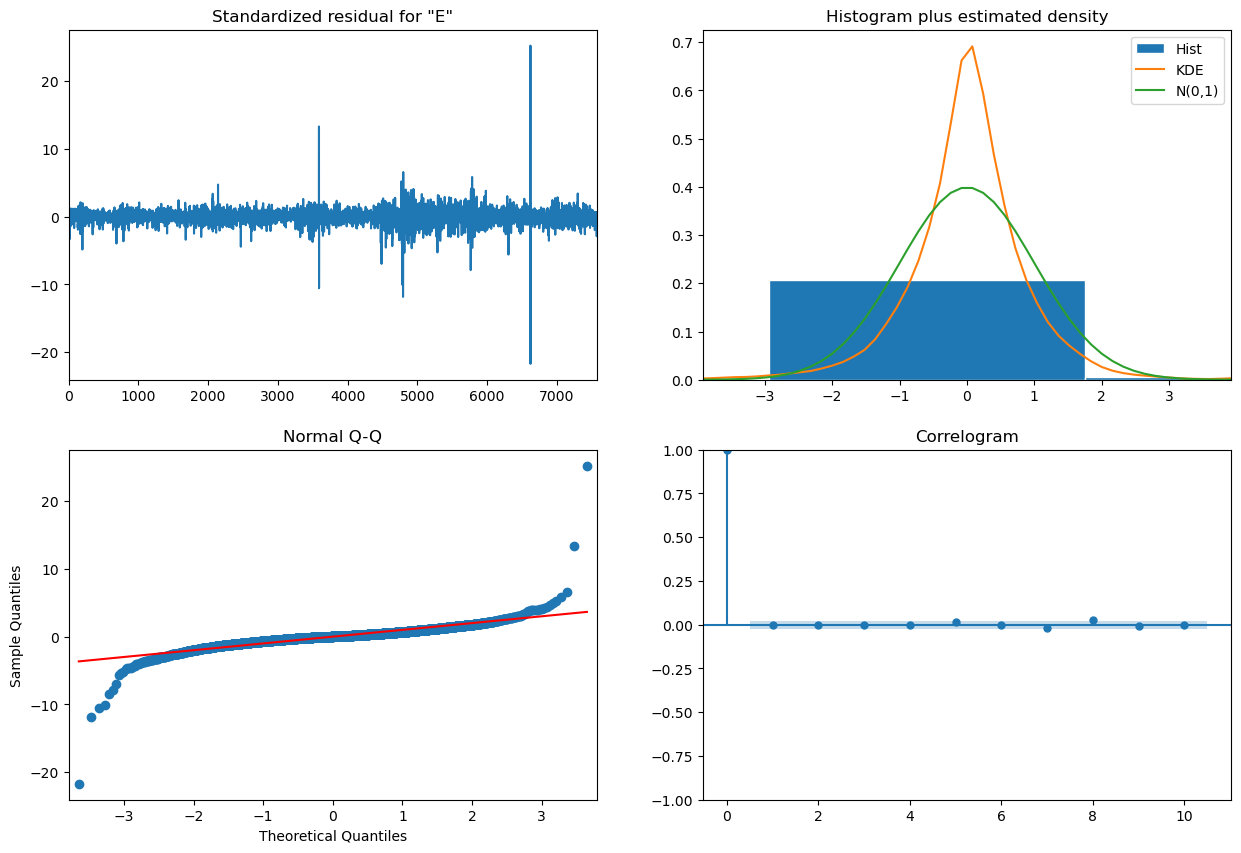

In [24]:
# Diagnostics plots
model_arima_fit.plot_diagnostics(figsize=(15,10))
plt.show()


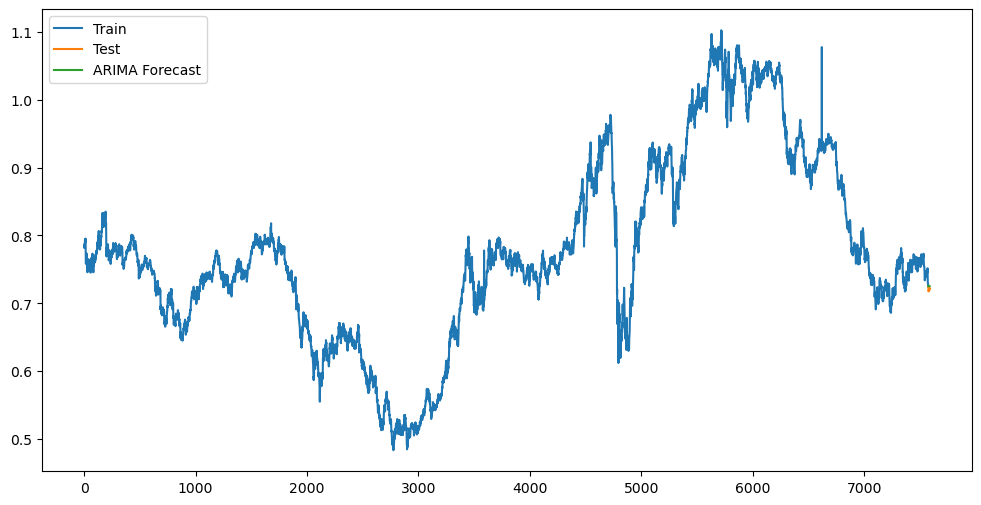

In [25]:
# Forecasting
forecast_arima = model_arima_fit.forecast(steps=12)
plt.figure(figsize=(12,6))
plt.plot(train.index, train['Ex_rate'], label='Train')
plt.plot(test.index, test['Ex_rate'], label='Test')
plt.plot(test.index, forecast_arima, label='ARIMA Forecast')
plt.legend()
plt.show()

#### Exponential Smoothing Model

In [26]:

# Fit Holt-Winters Exponential Smoothing
model_es = ExponentialSmoothing(train['Ex_rate'], trend='add', seasonal=None)
model_es_fit = model_es.fit()

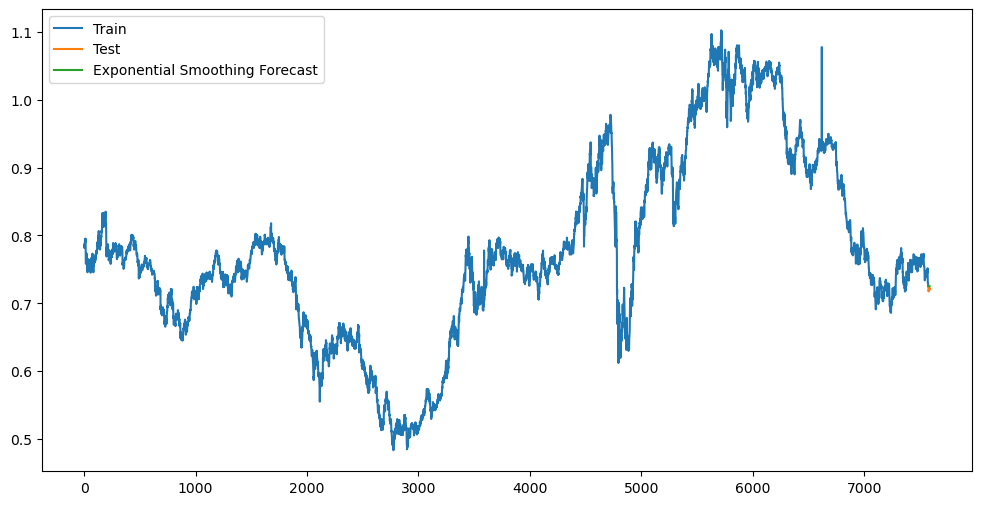

In [27]:
# Forecast
forecast_es = model_es_fit.forecast(12)
plt.figure(figsize=(12,6))
plt.plot(train.index, train['Ex_rate'], label='Train')
plt.plot(test.index, test['Ex_rate'], label='Test')
plt.plot(test.index, forecast_es, label='Exponential Smoothing Forecast')
plt.legend()
plt.show()

#### Evaluation and Comparison

In [28]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# ARIMA error metrics
mae_arima = mean_absolute_error(test['Ex_rate'], forecast_arima)
rmse_arima = np.sqrt(mean_squared_error(test['Ex_rate'], forecast_arima))
mape_arima = mape(test['Ex_rate'], forecast_arima)


In [29]:
# Exponential smoothing error metrics
mae_es = mean_absolute_error(test['Ex_rate'], forecast_es)
rmse_es = np.sqrt(mean_squared_error(test['Ex_rate'], forecast_es))
mape_es = mape(test['Ex_rate'], forecast_es)


In [30]:
# Print errors
print("ARIMA Model Errors:")
print(f"MAE: {mae_arima:.4f}, RMSE: {rmse_arima:.4f}, MAPE: {mape_arima:.2f}%")
print("\nExponential Smoothing Model Errors:")
print(f"MAE: {mae_es:.4f}, RMSE: {rmse_es:.4f}, MAPE: {mape_es:.2f}%")


ARIMA Model Errors:
MAE: 0.0049, RMSE: 0.0052, MAPE: 0.67%

Exponential Smoothing Model Errors:
MAE: 0.0048, RMSE: 0.0052, MAPE: 0.67%
